In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import control
from numpy import sin, cos, tan, pi
from control import TransferFunction as TF

In [2]:
import txt_mixin

In [3]:
plt.rcParams['font.size'] = 14

In [4]:
import py_block_diagram

In [5]:
import importlib

In [6]:
import sys

In [7]:
sys.path

['/home/ryanwkrauss/sabbatical_github_work/cart_pendulum/arduino_only',
 '/home/ryanwkrauss/git/research',
 '/home/ryanwkrauss/git/krauss_misc',
 '/home/ryanwkrauss/git/report_generation',
 '/home/ryanwkrauss/git/teaching',
 '/home/ryanwkrauss/git/bad',
 '/home/ryanwkrauss/git/py_block_diagram',
 '/usr/lib/python37.zip',
 '/usr/lib/python3.7',
 '/usr/lib/python3.7/lib-dynload',
 '',
 '/home/ryanwkrauss/.local/lib/python3.7/site-packages',
 '/usr/local/lib/python3.7/dist-packages',
 '/usr/local/lib/python3.7/dist-packages/bode_utils-1.1.0-py3.7.egg',
 '/usr/local/lib/python3.7/dist-packages/random_bode_generator-1.2.1-py3.7.egg',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.7/dist-packages/IPython/extensions',
 '/home/ryanwkrauss/.ipython']

In [8]:
importlib.reload(py_block_diagram)

<module 'py_block_diagram' from '/home/ryanwkrauss/git/py_block_diagram/py_block_diagram/__init__.py'>

In [9]:
import py_block_diagram as pybd

### Helper Function

- draw the block diagram as needed to verify things

In [10]:
def mydraw(block_list,xlim=None,ylim=None,grid=0):
    fig = plt.figure(figsize=(12,6))
    ax = fig.add_subplot(111)
    mysys = pybd.block_diagram(block_list,ax)
    mysys.draw()
    if xlim is not None:
        plt.xlim(xlim)
    if ylim is not None:
        plt.ylim(ylim)
    if grid:
        ax.grid(1)
    else:
        mysys.axis_off()
    return mysys, ax

## System Description

In [11]:
block_list = []

In [12]:
U = pybd.int_constant_block(3500,"U_cl")

In [13]:
U.width = 4

In [14]:
U.place_absolute(0,0)

In [15]:
block_list.append(U)

In [16]:
sum1 = pybd.summing_junction()

In [17]:
sum1.place_relative(U,"right")

In [18]:
sum1.set_input1(U)

In [19]:
block_list.append(sum1)

In [20]:
D = pybd.PD_controller(0.1,0.01)

In [21]:
D.place_relative(sum1,"right")

In [22]:
D.set_input_block(sum1)

In [23]:
block_list.append(D)

In [24]:
diff_motors = pybd.custom_actuator("dual_motors","two_motors_dbl_actuator","&motors")

In [25]:
line_sense = pybd.custom_sensor("line_sense","qtr_line_sensor","&qtr")

In [26]:
pend_enc = pybd.custom_sensor("pend_enc","pendulum_encoder","")

In [27]:
G = pybd.plant_with_double_actuator_two_sensors(pend_enc,\
                                                line_sense,\
                                                diff_motors,"Robot")

In [28]:
G.width = 5

In [29]:
sat = pybd.sat2_adjustable_block(150)

In [30]:
sat.set_input_block(D)

In [31]:
sat.width = 3.5

In [32]:
block_list.append(sat)

In [33]:
sat.place_relative(D, "right", 5)

In [34]:
add1 = pybd.addition_block()

In [35]:
subtract1 = pybd.subtraction_block()

In [36]:
v_nom = pybd.int_constant_block(200,'v_nom_block')

In [37]:
v_nom.width = 3

In [38]:
v_nom.place_relative(sat, "right", yshift=6, xshift=-9)

In [39]:
block_list.append(v_nom)

In [40]:
add1.place_relative(sat, "right", yshift=1, xshift=3)

In [41]:
subtract1.place_relative(sat, "right", yshift=-2)

In [42]:
block_list.append(add1)

In [43]:
block_list.append(subtract1)

In [44]:
satP = pybd.sat2_adjustable_block(400,label="satP",variable_name="satP")

In [45]:
satP.width = 4

In [46]:
satP.place_relative(add1,"right")

In [47]:
block_list.append(satP)

In [48]:
satP.set_input_block(add1)

In [49]:
satN = pybd.sat2_adjustable_block(400,label="satN",variable_name="satN")

In [50]:
satN.width = 4

In [51]:
satN.place_relative(subtract1,"right",5)

In [52]:
block_list.append(satN)

In [53]:
satN.set_input_block(subtract1)

In [54]:
G.set_inputs(satP,satN)

In [55]:
G.place_relative(sat,"right",18)

In [56]:
block_list.append(G)

In [57]:
Y = pybd.output_block("line position",G.sensor2)

In [58]:
Y.place_relative(G.sensor2, "right",10)

In [59]:
Y.width = 9

In [60]:
Y2 = pybd.output_block("pend. encoder", G.sensor1)

In [61]:
Y2.width = 10

In [62]:
Y2.place_relative(G.sensor1, "right", 10)

In [63]:
block_list.append(Y2)

In [64]:
sum1.set_input2(G.sensor2)

In [65]:
block_list.append(Y)

In [66]:
sum1.fb_vertical_offset = -5

In [67]:
U2 = pybd.int_constant_block(0,"U_pend")

In [68]:
U2.place_relative(U,"above",15,xshift=-3)

In [69]:
block_list.append(U2)

In [70]:
sum2 = pybd.summing_junction(variable_name='sum2')

In [71]:
sum2.place_relative(U2,"right")

In [72]:
block_list.append(sum2)

In [73]:
sum2.set_inputs(U2,G.sensor1)

In [74]:
D2 = pybd.PD_controller(3,0.1,variable_name='D_pend')

In [75]:
D2.set_input_block(sum2)

In [76]:
D2.place_relative(sum2,"right")

In [77]:
block_list.append(D2)

In [78]:
sat_pend = pybd.sat2_adjustable_block(200,variable_name='pend_sat')

In [79]:
sat_pend.width = 4

In [80]:
sat_pend.set_input_block(D2)

In [81]:
sat_pend.place_relative(D2,"right")

In [82]:
block_list.append(sat_pend)

In [83]:
add_pend = pybd.addition_block(variable_name="add_pend")

In [84]:
add_pend.set_input1(sat_pend)

In [85]:
add_pend.set_input2(v_nom)

In [86]:
add_pend.place_relative(sat_pend,"right",yshift=-3)

In [87]:
block_list.append(add_pend)

In [88]:
add1.set_inputs(add_pend, sat)

In [89]:
subtract1.set_inputs(add_pend, sat)

In [90]:
sum2.add_waypoint2((G.right_edge[0]+1,3))

In [91]:
sum2.add_waypoint2((sum2.x,3))

In [92]:
sum2.waypoints2

[(34.5, 3), (1, 3)]

In [93]:
subtract1.add_waypoint2((sat.right_edge[0]+0.5,-3))

In [94]:
subtract1.waypoints2

[(15.25, -3)]

calling draw_feedback_wire
calling draw_feedback_wire


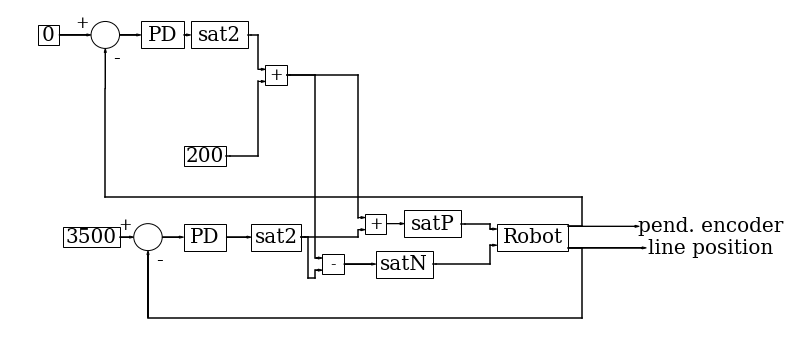

In [95]:
mysys, ax = mydraw(block_list)

In [96]:
sum2.all_waypoints2

[(34.5, 0.8), (34.5, 3), (1, 3), (1, 11)]